## 1 problem statement
From [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

Context
Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk need early detection and management wherein a machine learning model can be of great help.

You will develop models to predict how likely a particular person is in developint cardiovascular disease, given all the information below.

#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

## 2 prepare data

### 2.1 load dataset

In [1]:
# Load the dataset using pandas
import pandas as pd

df = pd.read_csv("data/heart.csv")

df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

### 2.2. One-hot encoding using Pandas

First you will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this you will just count how many different values there are in each categorical variable and consider only the variables with 3 or more values.

In [2]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(
    data = df,
    prefix = cat_variables,
    columns = cat_variables)

df.head()


Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0  False   True              False  ...              False             False   
1   True  False              False  ...               True             False   
2  False   True              False  ...              False             False   
3   True  False               True  ...              False             False   
4  False   True              False  ...               True             False   

   RestingECG_LVH  RestingECG_Normal  RestingECG_ST  ExerciseAngina_N  \
0           False               True          False              True   
1           False               True          False              True   
2           False              False           True              True   
3           False               True          False             False   
4           False               True          False              True   

   ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  
0             False          False          False         True  
1             False          False           True        False  
2             False          False          False         True  
3              True          False           True        False  
4             False          False          False         True  

[5 rows x 21 columns]

In [3]:
var = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable
print(len(var))


20


### 2.3 split dataset

In [4]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 55 ## You will pass it to every sklearn call so we ensure reproducibility

X_train, X_test, y_train, y_test = train_test_split(df[var], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)

print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
test samples: 184
target proportion: 0.5518


## 3 Decision Tree

### 3.1 build model

In [8]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

#### 3.1.1 experiment the min samples split num

In [25]:
import numpy as np
def get_approprate_x(accuracy_list_train, accuracy_list_test, x_list):
    res = -1
    max_distance = np.inf
    for i in range(len(x_list)):
        train_accuracy = accuracy_list_train[i]
        test_accuracy = accuracy_list_test[i]
        this_distance = (train_accuracy - test_accuracy) ** 2
        if this_distance < max_distance:
            res = i
            max_distance = this_distance
            
    return x_list[res]


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)


min_samples_split: 200


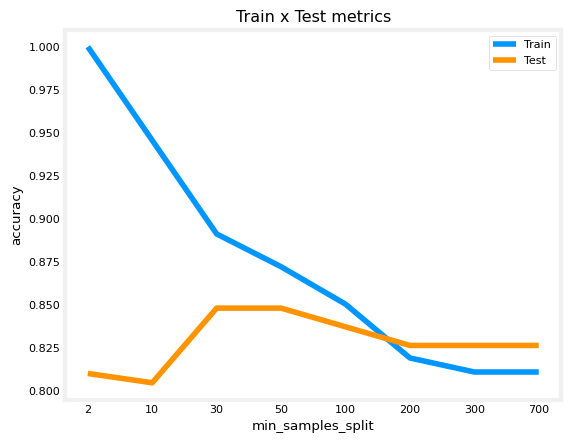

In [27]:
import matplotlib.pyplot as plt
plt.style.use('../lib/deeplearning.mplstyle')

def plot_accuracy(x_list, accuracy_list_train, accuracy_list_test, x_label):
    plt.title('Train x Test metrics')
    plt.xlabel(x_label)
    plt.ylabel('accuracy')
    plt.xticks(ticks = range(len(x_list )),labels=x_list)
    plt.plot(accuracy_list_train)
    plt.plot(accuracy_list_test)
    plt.legend(['Train','Test'])

plot_accuracy(min_samples_split_list, accuracy_list_train, accuracy_list_test, 'min_samples_split')
# print('min_samples_split: {}'.format(get_approprate_x(accuracy_list_train, accuracy_list_test, min_samples_split_list)))

#### 3.1.2 experiment the max depth

max_depth: 3


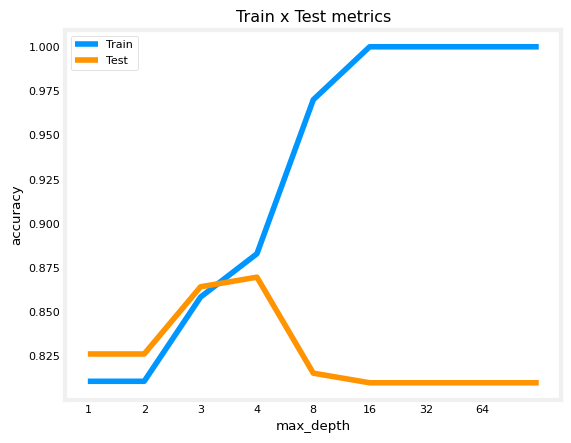

In [29]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot_accuracy(max_depth_list, accuracy_list_train, accuracy_list_test, 'max_depth')
print('max_depth: {}'.format(get_approprate_x(accuracy_list_train, accuracy_list_test, max_depth_list)))


#### 3.1.3 use best param to build model

The test accuracy reaches the highest at tree_depth=3. When the allowed depth is smaller, the tree cannot make enough splits to distinguish positives from negatives (having the underfit problem), but when the allowed depth is too high ( >= 5), the tree becomes too specialized to the training set and thus losing accuracy to the test dataset (having the overfit problem). Our final tree model then will have:

- `max_depth = 3`
- `min_samples_split = 50` 

In [31]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

### 3.2 predict

In [35]:
print("Metrics train:\n\tAccuracy score: {:.4f}\nMetrics test:\n\tAccuracy score: {:.4f}".format(
        accuracy_score(decision_tree_model.predict(X_train),y_train),
        accuracy_score(decision_tree_model.predict(X_test),y_test)
    ))

Metrics train:
	Accuracy score: 0.8583
Metrics test:
	Accuracy score: 0.8641


## 4 Random Forest

### 4.1 build model

Now let's try the Random Forest algorithm also, using the Scikit-learn implementation. Naturally, all of the above hyperparameters will exist in this algorithm, since it is just an ensemble of Decision Trees, but will have another hyperparameter that you will use, called `n_estimators` which is how many different Decision Trees will be fitted. 

Remember that for a Random Forest, you use a subset of the features AND a subset of the training set to train each tree, chosen randomly. In this case, you will use the number of features as you saw in the lecture, which is $\sqrt{n}$ where $n$ is the number of features. However, this can be modified. For further information on the Random Forest hyperparameters, you can run `help(RandomForestClassifier)`.

Another parameter that does not impact on the final result but can speed up the computation is called `n_jobs`. Since the fitting of each tree is independent of each other, it is possible to run parallel fits. So setting `n_jobs` higher will increase how many CPU cores it will use. Note that the numbers very close to the maximum cores of your CPU may impact on the overall performance of your PC and even lead to freezes. 

You will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

In [36]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

#### 4.1.1 experiment the min samples split

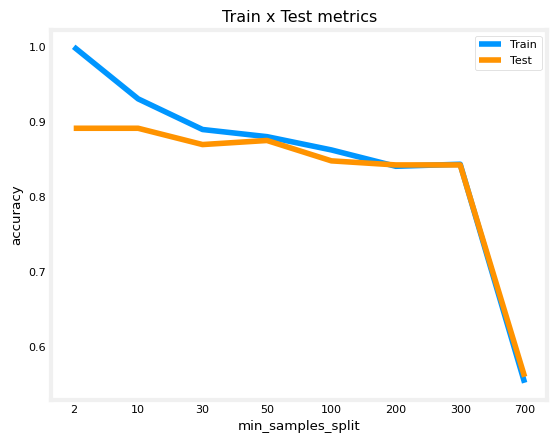

In [38]:
from sklearn.ensemble import RandomForestClassifier

accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot_accuracy(min_samples_split_list, accuracy_list_train, accuracy_list_test, 'min_samples_split')

#### 4.1.2 experiment the max depth


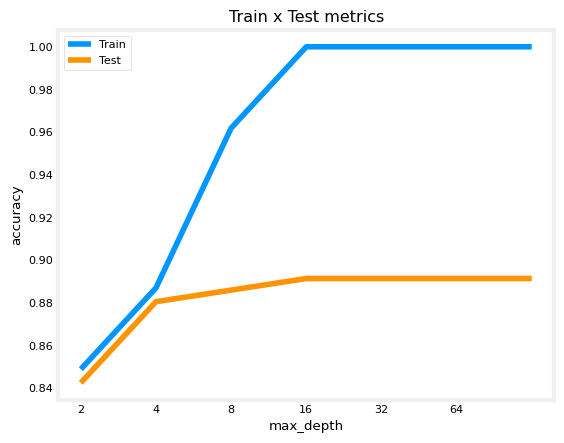

In [39]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot_accuracy(max_depth_list, accuracy_list_train, accuracy_list_test, 'max_depth')


#### 4.1.3 experiment the optimal tree numbers

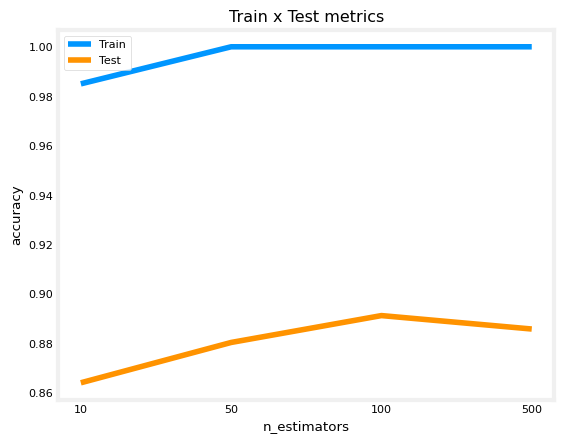

In [40]:
accuracy_list_train = []
accuracy_list_test = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plot_accuracy(n_estimators_list, accuracy_list_train, accuracy_list_test, 'n_estimators')


#### 4.1.4 use best param to build model

Let's then fit a random forest with the following parameters:

 - max_depth: 8
 - min_samples_split: 10
 - n_estimators: 100

In [42]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 8, 
                                             min_samples_split = 10).fit(X_train,y_train)

### 4.2 predict

In [43]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9196
Metrics test:
	Accuracy score: 0.8913


You have demonstrated how to look for the best value hyperparameter-by-hyperparameter. However, you should not overlook that as we experiment with one hyperparameter we always have to fix the others at some default values. This makes us only able to tell how the hyperparameter value changes with respect to those defaults. 

In princple, if you have 4 values to try out in each of the 3 hyperparameters being tuned, you should have a total of 4 x 4 x 4 = 64 combinations, however, the way you are doing will only give us 4 + 4 + 4 = 12 results. 

To try out all combinations, you can use a sklearn implementation called GridSearchCV, moreover, it has a refit parameter that will automatically refit a model on the best combination so you will not need to program it explicitly. 

For more on GridSearchCV, please refer to its [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

## 5 XGBoost

Now, the last model you will test in this lab is the Gradient Boosting model, called XGBoost. As you've seen in the lectures, the boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fitted subsequently to minimize the error. 

The parameters that this model comprises is the same as the parameters for any decision tree, plus some others, such as:
- the learning rate, which is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that it allows, during the fit, to pass a list evaluation datasets of the form `(X_val,y_val)`, where on each iteration, it measures the cost (or evaluation metric) on the evaluation datasets so that once the cost (or metric) stops to descrease for a number of rounds (called early_stopping_rounds), the training will stop. 

This is how we can automatically control how many estimators is enough, and how we can avoid overfitting due to too many estimators.

### 5.1 build model

First, let's define a subset of our training set (we should not use the test set here).

In [5]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds=50)

# The parameter early_stopping_rounds:
#   - is the number of iterations that it will wait to check if the cost function decreased or not.
#   - If not, it will stop and get the iteration that returned the lowest metric on the eval set.

xgb_model.fit(X_train_fit,y_train_fit, eval_set=[(X_train_eval,y_train_eval)])

# Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. 

xgb_model.best_iteration

[0]	validation_0-logloss:0.63302
[1]	validation_0-logloss:0.59554
[2]	validation_0-logloss:0.56614
[3]	validation_0-logloss:0.54187
[4]	validation_0-logloss:0.52349
[5]	validation_0-logloss:0.50611
[6]	validation_0-logloss:0.49373
[7]	validation_0-logloss:0.48366
[8]	validation_0-logloss:0.47323
[9]	validation_0-logloss:0.46538
[10]	validation_0-logloss:0.46000
[11]	validation_0-logloss:0.45621
[12]	validation_0-logloss:0.45483
[13]	validation_0-logloss:0.44975
[14]	validation_0-logloss:0.44495
[15]	validation_0-logloss:0.44073
[16]	validation_0-logloss:0.44078
[17]	validation_0-logloss:0.43936
[18]	validation_0-logloss:0.44206
[19]	validation_0-logloss:0.44536
[20]	validation_0-logloss:0.44322
[21]	validation_0-logloss:0.44310
[22]	validation_0-logloss:0.44419
[23]	validation_0-logloss:0.44797
[24]	validation_0-logloss:0.44843
[25]	validation_0-logloss:0.45337
[26]	validation_0-logloss:0.45206
[27]	validation_0-logloss:0.45435
[28]	validation_0-logloss:0.45316
[29]	validation_0-loglos

17

As you can see, even though you passed 500 estimators to fit, the algorithm only fitted 66 because the log-loss used to metrify the training rounds started to increase. In fact, the number of estimators is even less than 66. If you take a closeer look to the metrics, you see that with 16 fitted trees, we achieved the minimum value of the log-loss, and in fact, this is the number of fitted trees in the final model:

### 5.2 predict

In [12]:
from sklearn.metrics import accuracy_score

print("Metrics train:\n\tAccuracy score: {:.4f}\nMetrics test:\n\tAccuracy score: {:.4f}".format(
    accuracy_score(xgb_model.predict(X_train),y_train),
    accuracy_score(xgb_model.predict(X_test),y_test)
))

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.8533


You can see that RandomForest achieved the best accuracy, but the results overall were close. 

And note that we got a very close test metric with XGBoost compared to RandomForest, and we didn't even performed any hyperparameter search! 

The advantage of XGBoost is that it is faster than the Random Forest and also it has more parameters, therefore you are able to fine-tune the model to achieve even better results.